<a href="https://colab.research.google.com/github/mikipacman/ML_images_playground/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST classification
This small notebook provides example on solving MNIST classification with CNN. I used keras and netpune to track metrics in an organized way (it is not neccessary in small projects like this, but I treat this notebook as an example of nice workflow for working with image classification in keras)

In [ ]:
pip install neptune-client

# Import data and define model

In [28]:
import os
from getpass import getpass
import keras 
import neptune
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Reshape, Flatten, Dropout, LeakyReLU
from keras.regularizers import l1_l2
from keras.optimizers import Adadelta
from keras.utils import to_categorical
import numpy as np
from keras.datasets.mnist import load_data

os.environ["NEPTUNE_API_TOKEN"] = getpass("Enter neptune api token")
neptune.init(project_qualified_name='miki.pacman/images')
(x_train, y_train), (x_test, y_test) = load_data(path="mnist.npz")
img_shape = x_train.shape[1:] + (1,)

x_train = np.reshape(x_train, (len(x_train),) + img_shape)
x_test = np.reshape(x_test, (len(x_test),) + img_shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

keras.backend.set_image_data_format('channels_last')

# Params
params = {
    'lr_start': 0.01,
    'batch_size': 32,
}

# Model definition
model = Sequential([
    Conv2D(16, (3, 3), padding="same", input_shape=img_shape),
    LeakyReLU(0.3),
    MaxPool2D(),

    Conv2D(32, (3, 3), padding="same"),
    LeakyReLU(0.3),
    MaxPool2D(),

    Conv2D(64, (3, 3), padding="same"),
    LeakyReLU(0.3),
    MaxPool2D(),

    Conv2D(128, (3, 3), padding="same"),
    LeakyReLU(0.3),
    MaxPool2D(),

    Flatten(),
    Dense(10, activation="sigmoid"),
])
print(model.summary())

model.compile(loss='binary_crossentropy', 
              optimizer=Adadelta(learning_rate=params['lr_start']),
              metrics=['categorical_accuracy'])

Enter neptune api token··········
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)   

# Define callbacks

In [4]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import Callback
import neptune
import os
import time
from PIL import Image


# Define callbacks and monitor
class NeptuneMonitor(Callback):
    def __init__(self, *, test_set=None, send_images=False):
        Callback.__init__(self)
        self.start_time = time.time()
        self.test_set = test_set
        self.send_images = send_images
        if send_images:
            for i, img in enumerate(test_set):
                img = (img * 255).astype('uint8')
                neptune.send_image(f"image_{i}", img)
            

    def on_epoch_end(self, epoch, logs={}):
        for k, v in logs.items():
            neptune.send_metric(k, epoch, v)
        neptune.send_metric('time_elapsed', epoch, time.time() - self.start_time)

        if self.send_images:
            imgs = self.model.predict(self.test_set)
            imgs = imgs.reshape(len(imgs), img_shape[0], img_shape[1], img_shape[2]) * 255
            imgs = imgs.astype('uint8')

            for i, img in enumerate(imgs):
                neptune.send_image(f"image_{i}", img)


reduceLR = ReduceLROnPlateau(factor=0.3, patience=3, verbose=1)
earlyStop = EarlyStopping(restore_best_weights=True, verbose=1, patience=30)

# Run it!

In [5]:
# Run that s***!
with neptune.create_experiment(name="mnist classification", params=params):
    model.fit(x_train, 
              y_train, 
              batch_size=params["batch_size"],
              epochs=1000,
              validation_split=0.1,
              shuffle=True,
              callbacks=[NeptuneMonitor(), reduceLR, earlyStop])

https://ui.neptune.ai/miki.pacman/images/e/IM-86
Epoch 1/1000
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4815 - categorical_accuracy: 0.6380 - val_loss: 0.0954 - val_categorical_accuracy: 0.8820
Epoch 2/1000
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0840 - categorical_accuracy: 0.8941 - val_loss: 0.0555 - val_categorical_accuracy: 0.9353
Epoch 3/1000
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0574 - categorical_accuracy: 0.9297 - val_loss: 0.0446 - val_categorical_accuracy: 0.9500
Epoch 4/1000
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0455 - categorical_accuracy: 0.9452 - val_loss: 0.0367 - val_categorical_accuracy: 0.9593
Epoch 5/1000
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0384 - categorical_accuracy: 0.9543 - val_loss: 0.0317 - val_categorical_accuracy: 0.9655
Epoch 6/1000
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0334 - categorical_ac

# Test it
We can look at learning curves here: https://ui.neptune.ai/miki.pacman/images/e/IM-86

In [6]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0126 - categorical_accuracy: 0.9856


[0.01261676661670208, 0.9855999946594238]

# Nice, here are some example predictions

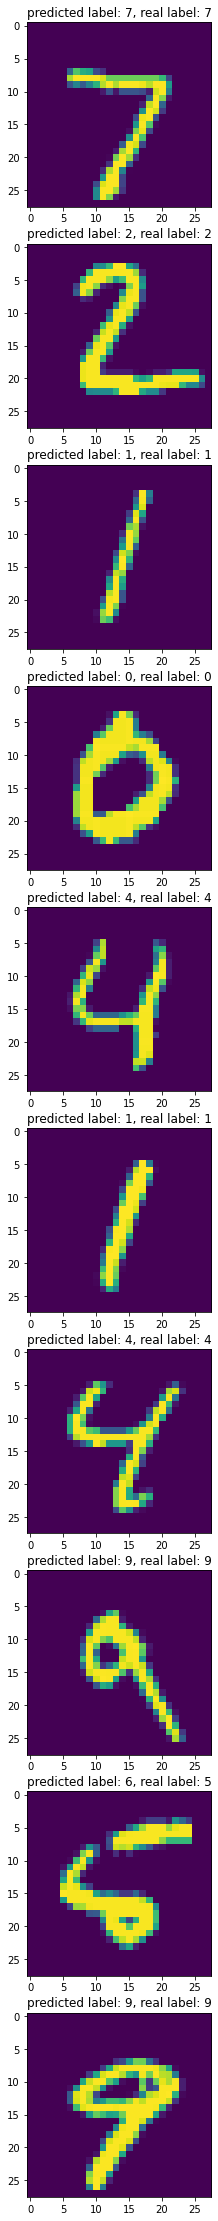

In [27]:
import matplotlib.pyplot as plt

n = 10
fig, ax = plt.subplots(n, figsize=(10, 40))
for im, label, i in zip(x_test[:n], y_test[:n], range(n)):
    ax[i].imshow(im[:, :, 0])
    pred = np.argmax(model.predict(im.reshape(1, 28, 28, 1))[0])
    real = np.argmax(label)
    ax[i].set_title(f"predicted label: {pred}, real label: {real}")